# Обзор обучающего датасета

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve, f1_score, precision_score, r2_score)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from scipy.stats import mannwhitneyu
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
%config InlineBackend.figure_format = 'png'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [5]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1)

In [6]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [7]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Home Ownership - домовладение

Annual Income - годовой доход

Years in current job - количество лет на текущем месте работы

Tax Liens - налоговые обременения

Number of Open Accounts - количество открытых счетов

Years of Credit History - количество лет кредитной истории

Maximum Open Credit - наибольший открытый кредит

Number of Credit Problems - количество проблем с кредитом

Months since last delinquent - количество месяцев с последней просрочки платежа

Bankruptcies - банкротства

Purpose - цель кредита

Term - срок кредита

Current Loan Amount - текущая сумма кредита

Current Credit Balance - текущий кредитный баланс

Monthly Debt - ежемесячный долг

Credit Score - баллы кредитного рейтинга

Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [8]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [9]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [10]:
num_features = df.select_dtypes(exclude='object').drop(columns='Credit Default').columns.to_list()
cat_features = df.select_dtypes(include='object').columns.to_list()

### Смотрим на распределения численных признаков, совпадение их мат ожиданий с помощью критерия Манна-Уитни
Видим, что у банкротств мат ожидания не совпадают (pvalue=0.036)

Annual Income
MannwhitneyuResult(statistic=9362155.5, pvalue=0.45908193952511717)


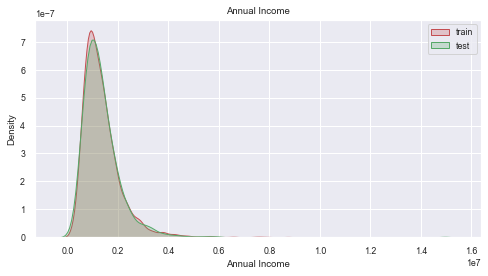

Tax Liens
MannwhitneyuResult(statistic=9336937.5, pvalue=0.09836860283803656)


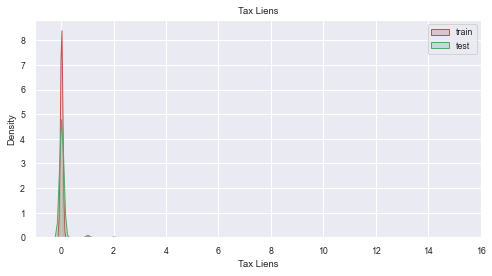

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


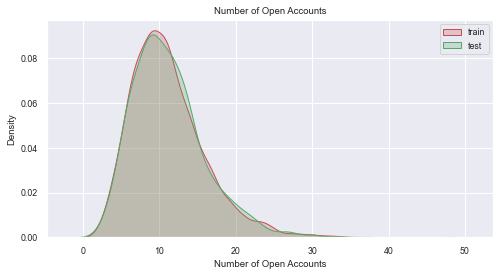

Years of Credit History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


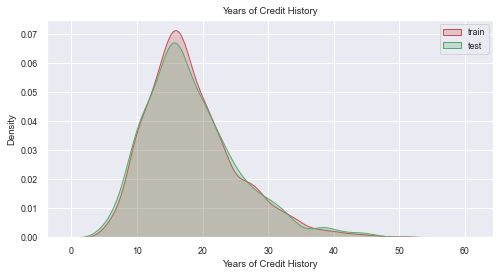

Maximum Open Credit
MannwhitneyuResult(statistic=9337869.0, pvalue=0.3832220993414893)


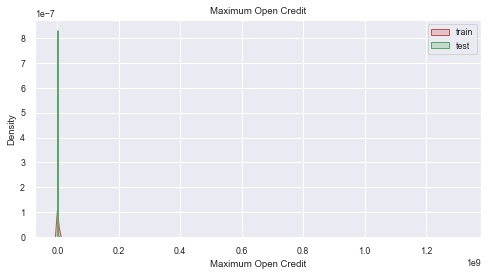

Number of Credit Problems
MannwhitneyuResult(statistic=9295513.5, pvalue=0.14195772552376257)


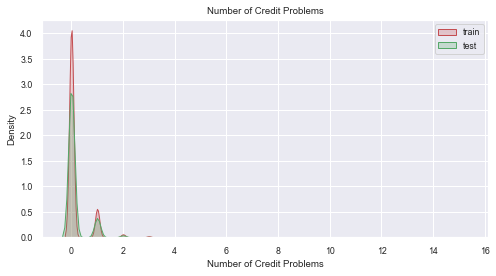

Months since last delinquent
MannwhitneyuResult(statistic=6974400.5, pvalue=1.712573746209761e-82)


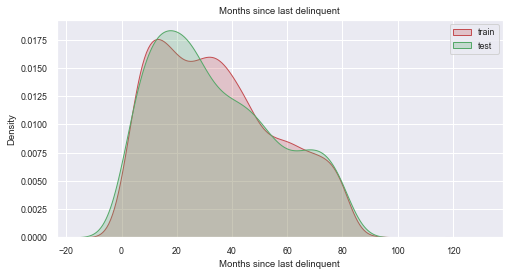

Bankruptcies
MannwhitneyuResult(statistic=9254231.0, pvalue=0.036681545859698156)


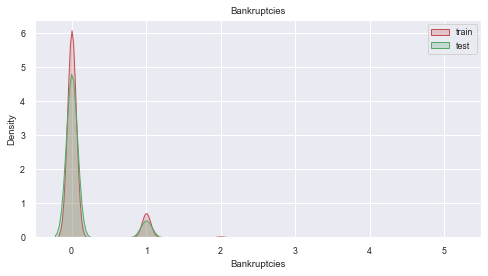

Current Loan Amount
MannwhitneyuResult(statistic=9230199.5, pvalue=0.12317435968682072)


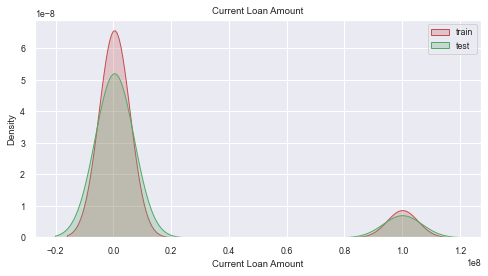

Current Credit Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


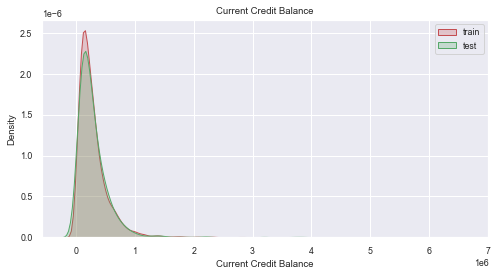

Monthly Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


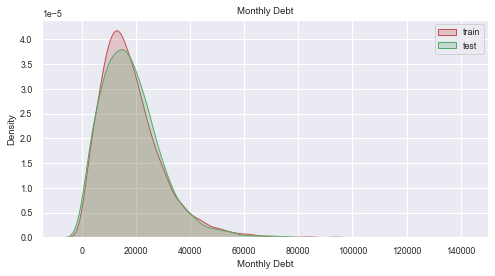

Credit Score
MannwhitneyuResult(statistic=9359581.5, pvalue=0.45091647518794764)


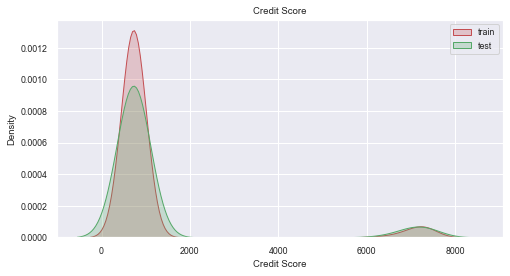

In [11]:
figsize = (8, 4)
for col in num_features:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(df[col], shade=True, label='train', color='r')
    sns.kdeplot(test[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(df[col], test[col]))
    plt.legend()
    plt.title(col)
    plt.show()

### Строим гистограммы по категориальным признакам

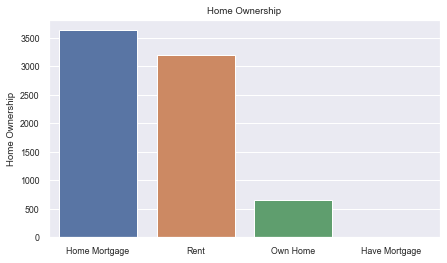

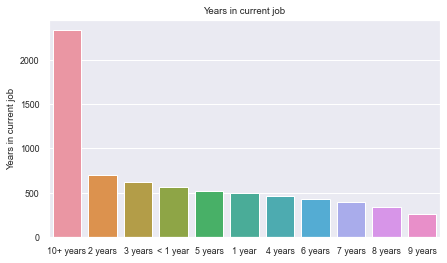

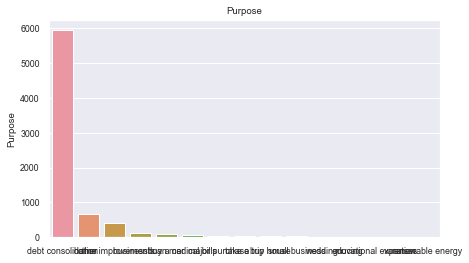

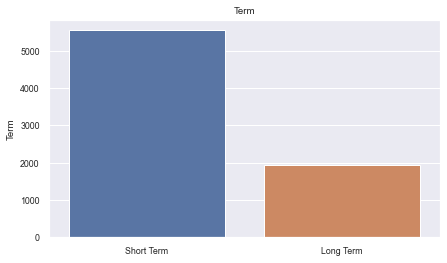

In [12]:
for col_name in cat_features:
    plt.figure(figsize=(7,4))
    sns.barplot(df[col_name].value_counts().index, df[col_name].value_counts()).set_title(col_name)
    plt.show()

### Видим дисбаланс целевой метки

In [13]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

### Строим корреляционную матрицу признаков

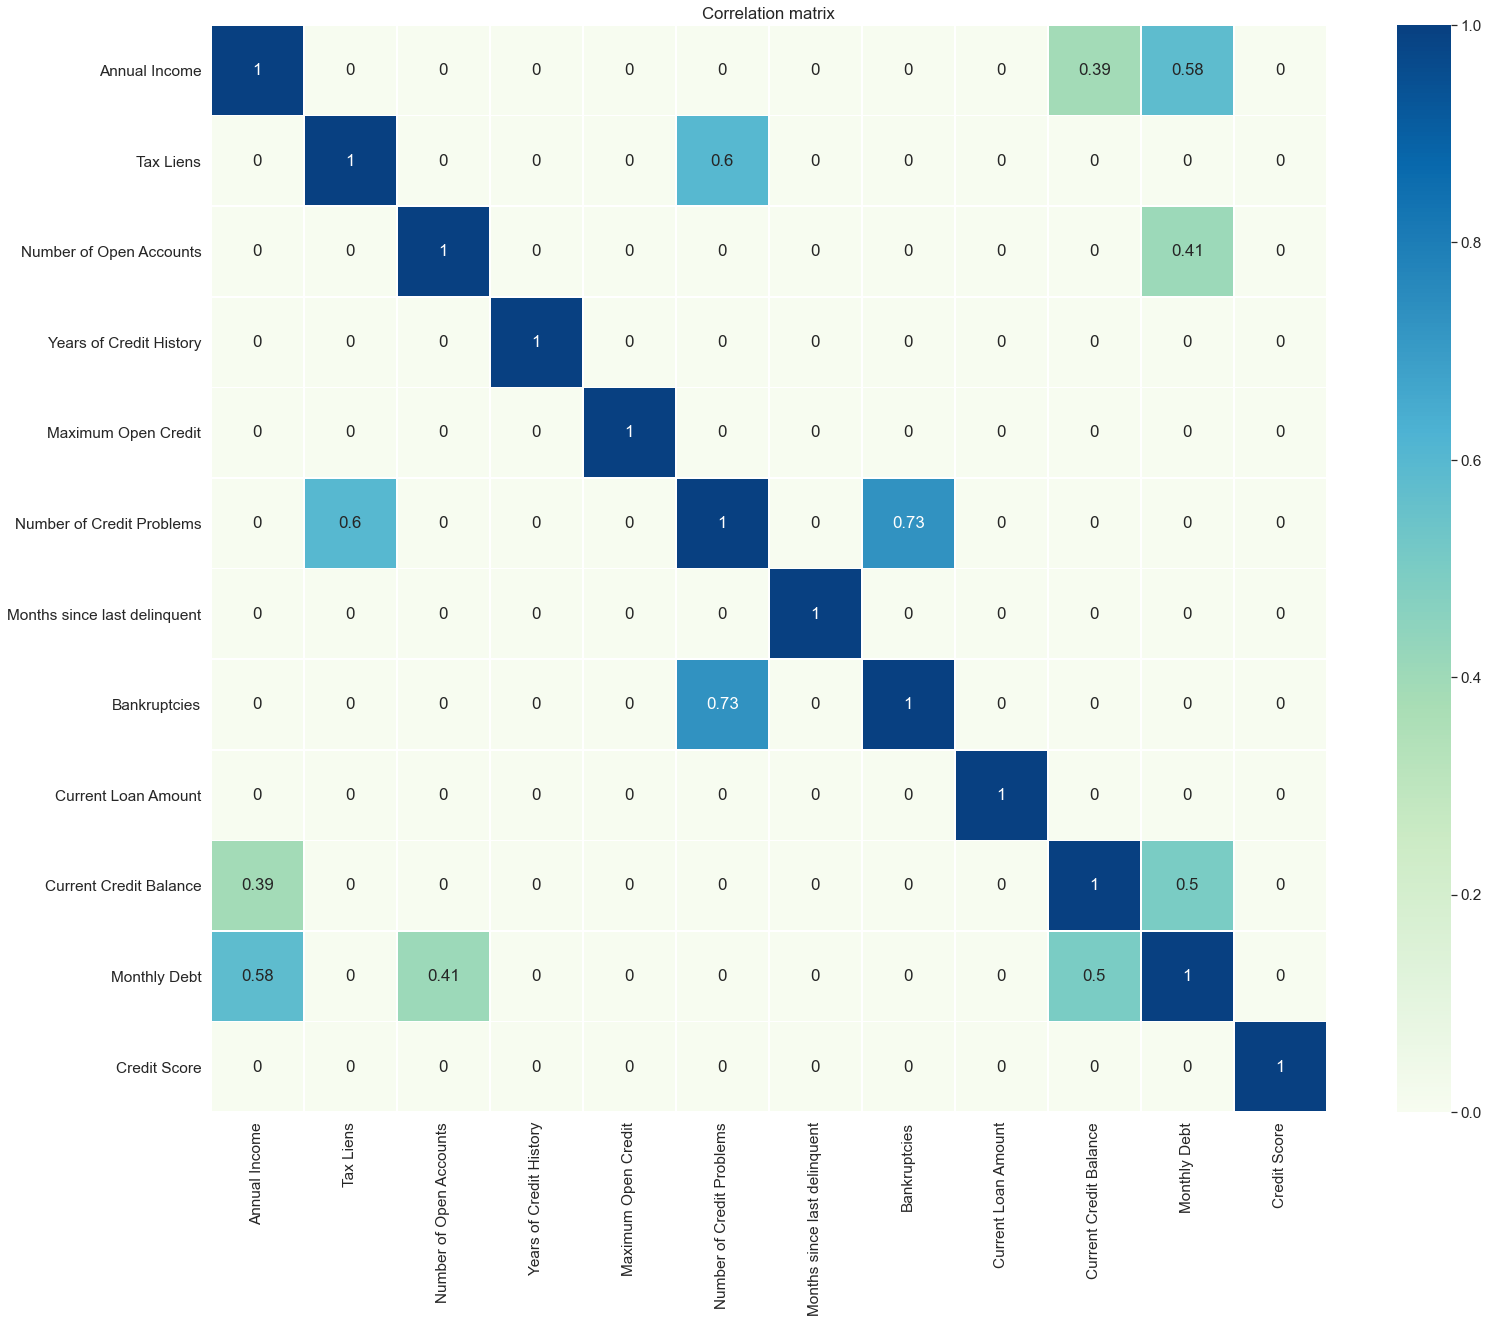

In [14]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)

corr_matrix = df[num_features].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Смотрим, как численные признаки коррелируют с целевой меткой

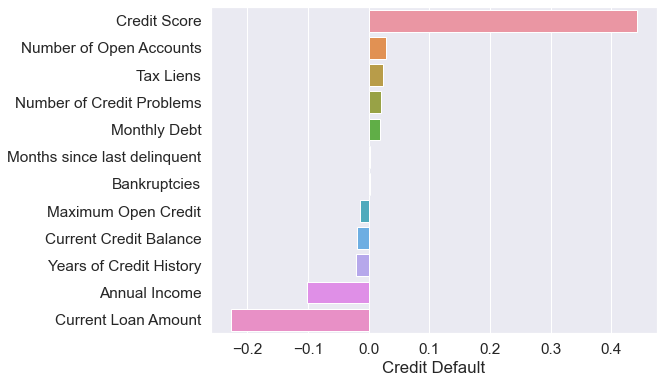

In [15]:
corr_with_target = df.corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(corr_with_target, corr_with_target.index)
plt.show()

# Обработка пропусков

### Посмотрим на пропущенные значения

In [16]:
df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

### Годовой доход, число месяцев с последней просрочки, банкротства и кредитный рейтинг заполним медианой

In [17]:
df['Annual Income'].median()

1168386.0

In [18]:
df['Annual Income'].fillna(df['Annual Income'].median(), inplace=True)
df['Months since last delinquent'].fillna(df['Months since last delinquent'].median(), inplace=True)
df['Bankruptcies'].fillna(df['Bankruptcies'].median(), inplace=True)
df['Credit Score'].fillna(df['Credit Score'].median(), inplace=True)

### Стаж на текущей работе заполним модой, потом надо заполнить на "менее года" и сравнить

In [19]:
df['Years in current job'].mode()

0    10+ years
dtype: object

In [20]:
df['Years in current job'].fillna(df['Years in current job'].mode()[0], inplace=True)

In [21]:
for cat_col_name in df.select_dtypes(include='object'):
    print(str(cat_col_name) + '\n\n' + str(df[cat_col_name].value_counts()) + '\n' + '_' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
____________________________________________________________________________________________________

Years in current job

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
____________________________________________________________________________________________________

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [22]:
num_features = df.select_dtypes(exclude='object').drop(columns='Credit Default').columns.to_list()
cat_features = df.select_dtypes(include='object').columns.to_list()

In [23]:
num_features

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [24]:
cat_features

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

### Масштабирование и разбиение на train & test

In [25]:
cat_features

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [26]:
encoder = LabelEncoder()
for cat_feature in cat_features:
    df[cat_feature] = encoder.fit_transform(df[cat_feature])

In [27]:
df.Purpose

0       3
1       3
2       3
3       3
4       3
       ..
7495    9
7496    3
7497    1
7498    3
7499    3
Name: Purpose, Length: 7500, dtype: int64

In [28]:
scaler = StandardScaler()
df_norm = df.copy()
df_norm[num_features] = scaler.fit_transform(df_norm[num_features])
df = df_norm.copy()

In [29]:
num_features

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [30]:
target_name = 'Credit Default'
X = df.drop(columns=target_name)
y = df[target_name]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33, stratify=y)

In [32]:
y_train

1454    0
1388    0
6135    1
4285    1
6300    1
       ..
165     0
5407    0
5879    0
3899    0
5888    1
Name: Credit Default, Length: 5025, dtype: int64

### Попробую заполнять пропуски моделями случайного леса

In [33]:
def fill_na(data, target_col, col_type='num', model=None):
    data = data.copy()
    cols_with_nan = data.isna().sum()[data.isna().sum() != 0].drop(target_col).index.to_list()
    
    features = data.columns
    data = data[features]
    
    if 'Credit Default' in data.columns:
        train = data[~data[target_col].isna()].drop(columns='Credit Default')
        predict_data = data[data[target_col].isna()].drop(columns='Credit Default')
    else:
        train = data[~data[target_col].isna()]
        predict_data = data[data[target_col].isna()]
    
#     train = data[~data[target_col].isna()]
#     predict_data = data[data[target_col].isna()]
    if model:
        cols_with_nan.append(target_col)
#         print(predict_data.drop(columns=cols_with_nan))
        pred = model.predict(predict_data.drop(columns=cols_with_nan))
        data.loc[data[target_col].isna(), target_col] = list(pred)
        return data

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
    params = {'n_estimators': [50, 100],
              'max_depth': [5, 10],
              'min_samples_leaf': [10, 20]}
    if col_type=='num':
        gs = GridSearchCV(RandomForestRegressor(random_state=42), params, scoring='r2')
        gs.fit(X_train.drop(columns=cols_with_nan), y_train)
        model = gs.best_estimator_

        pred_train = model.predict(X_train.drop(columns=cols_with_nan))
        pred_test = model.predict(X_test.drop(columns=cols_with_nan))

        print(f"r2 на train: {r2_score(y_train, pred_train)}")
        print(f"r2 на test: {r2_score(y_test, pred_test)}")
    
    elif col_type=='cat':
        gs = GridSearchCV(RandomForestClassifier(random_state=42), params, scoring='r2')
        gs.fit(X_train.drop(columns=cols_with_nan), y_train)
        model = gs.best_estimator_
   
        pred_train = model.predict(X_train.drop(columns=cols_with_nan))
        pred_test = model.predict(X_test.drop(columns=cols_with_nan))

        print(f"f1 на train: {f1_score(y_train, pred_train, average='macro')}")
        print(f"f1 на test: {f1_score(y_test, pred_test, average='macro')}")
      
    return model

### Сделаю класс для удобной предобработки данных

In [247]:
class DataPreprocessing:
    def __init__(self):
        self.medians=None
        self.mode=None
        self.cat_features=None
        self.encoder = LabelEncoder()
        self.scaler = StandardScaler()
        self.target = None
        self.features = None
        self.credit_score_model = None
        self.annual_income_model = None
        self.month_model = None
        self.bankruptcies_model = None
        self.job_years_model = None
    def fit(self, X):
#         for cat_feature in cat_features:
#             X.loc[~X[cat_feature].isna(), cat_feature] = \
#             self.encoder.fit_transform(X.loc[~X[cat_feature].isna(), cat_feature])
        self.medians = X.median()
        self.modes = X.mode()
#         self.credit_score_model = fill_na(X, 'Credit Score')
#         X = fill_na(X, 'Credit Score', model=self.credit_score_model)
#         self.annual_income_model = fill_na(X, 'Annual Income')
#         X = fill_na(X, 'Annual Income', model=self.annual_income_model)
#         self.month_model = fill_na(X, 'Months since last delinquent')
#         X = fill_na(X, 'Months since last delinquent', model=self.month_model)
#         self.bankruptcies_model = fill_na(X, 'Bankruptcies')
#         X = fill_na(X, 'Bankruptcies', model=self.bankruptcies_model)
#         self.job_years_model = fill_na(X, 'Years in current job')
#         X = fill_na(X, target_col='Years in current job', model=self.job_years_model)
    def transform(self, X):
        self.cat_features = X.select_dtypes(include='object').columns.to_list()
        self.num_features = X.select_dtypes(exclude='object').columns.to_list()
        if 'Credit Default' in self.num_features:
            self.num_features.remove('Credit Default')
#         for cat_feature in cat_features:
#             X.loc[~X[cat_feature].isna(), cat_feature] = \
#             self.encoder.fit_transform(X.loc[~X[cat_feature].isna(), cat_feature])
#         X = fill_na(X, 'Credit Score', model=self.credit_score_model)
#         X = fill_na(X, 'Annual Income', model=self.annual_income_model)
#         X = fill_na(X, 'Months since last delinquent', model=self.month_model)
#         X = fill_na(X, 'Bankruptcies', model=self.bankruptcies_model)
#         X = fill_na(X, target_col='Years in current job', model=self.job_years_model)
        X['Credit Score'].fillna(self.medians['Credit Score'], inplace=True)
        X['Annual Income'].fillna(self.medians['Annual Income'], inplace=True)
        X['Months since last delinquent'].fillna(0, inplace=True)
        X['Bankruptcies'].fillna(self.medians['Bankruptcies'], inplace=True)
        X['Years in current job'].fillna(self.modes['Years in current job'], inplace=True)
        for cat_feature in self.cat_features:
                X[cat_feature] = X[cat_feature].astype('str')
                X[cat_feature] = self.encoder.fit_transform(X[cat_feature])
#                 X[cat_feature] = X[cat_feature].astype('str')
        X[self.num_features] = self.scaler.fit_transform(X[self.num_features]) 

        X['Years in current job'] = X['Years in current job'].astype('int')
        return X

In [270]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [271]:
preprocessing = DataPreprocessing()
preprocessing.fit(train)
train = preprocessing.transform(train)
test = preprocessing.transform(test)
train

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,2,-1.114304,1,-0.110953,-0.026674,1.133645,-0.016174,1.664779,-0.698307,2.545732,3,1,2.760520,-0.762772,-0.872085,-0.218932,0
1,2,-0.396190,1,-0.110953,0.788223,-0.428528,0.014763,-0.340979,-0.698307,-0.337099,3,0,-0.363620,0.330781,0.004909,-0.227276,1
2,1,-0.758385,8,-0.110953,-0.026674,2.369181,0.014807,-0.340979,-0.698307,-0.337099,3,1,2.760520,0.058379,-0.391034,-0.223799,0
3,2,-0.687478,6,-0.110953,-0.637847,0.593985,-0.049781,1.664779,-0.698307,2.545732,3,1,-0.368118,-0.610282,-0.584980,-0.257174,0
4,3,-0.725543,8,-0.110953,0.380774,-0.669954,-0.034902,1.664779,-0.698307,-0.337099,3,1,-0.367978,-0.618292,-0.933631,-0.239791,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,3,-1.219886,10,-0.110953,-1.656468,-1.394234,-0.052248,-0.340979,-0.698307,-0.337099,9,1,-0.367868,-0.680639,-1.376362,-0.255088,0
7496,1,0.275799,0,-0.110953,-0.230398,1.162048,-0.016152,-0.340979,1.200322,-0.337099,3,0,-0.358011,0.524039,-0.463816,4.412423,1
7497,3,0.731625,6,-0.110953,0.177050,1.957336,0.052029,-0.340979,-0.698307,-0.337099,1,1,2.760520,0.591407,-0.489306,-0.219628,0
7498,1,-0.207346,11,-0.110953,2.010568,1.162048,0.012237,-0.340979,-0.698307,-0.337099,3,1,-0.352647,0.585907,1.576689,-0.231448,0


In [272]:
test.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

In [273]:
target_name = 'Credit Default'
X = train.drop(columns=target_name)
y = train[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

### Построение и оценка базовых моделей

#### k neighbors - сильное переобучение, f1 для 1 класса на трейне 0.61, на тесте 0.43, макро f1 0.74 и 0.62 соответственно

In [255]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
evaluate_preds(model_knn, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.94      0.88      4310
           1       0.77      0.48      0.59      1690

    accuracy                           0.81      6000
   macro avg       0.80      0.71      0.74      6000
weighted avg       0.81      0.81      0.80      6000

TEST

              precision    recall  f1-score   support

           0       0.77      0.89      0.83      1077
           1       0.54      0.33      0.41       423

    accuracy                           0.73      1500
   macro avg       0.66      0.61      0.62      1500
weighted avg       0.71      0.73      0.71      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               960  117
1               285  138


#### Support Vector Classifier - без гиперпараметров плохо классифицирует 1 класс, f1 для первого класса всего 0.36, средний f1 score = 0.62 на тесте, зато нет переобучения, на тесте метрики даже чуть лучше. Веса классов далее хорошо себя показывают и значительно повышают метрики - f1 для первого класса = 53, средний f1 = 0,65

In [256]:
model_svc = LinearSVC(random_state=42)
model_svc.fit(X_train, y_train)
evaluate_preds(model_svc, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.99      0.86      4310
           1       0.90      0.23      0.37      1690

    accuracy                           0.78      6000
   macro avg       0.83      0.61      0.62      6000
weighted avg       0.80      0.78      0.72      6000

TEST

              precision    recall  f1-score   support

           0       0.77      0.99      0.87      1077
           1       0.94      0.25      0.39       423

    accuracy                           0.78      1500
   macro avg       0.85      0.62      0.63      1500
weighted avg       0.82      0.78      0.73      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1070    7
1                318  105


#### LightGBM - сильное переобучение, f1 для 1 класса на трейне 0.82, а на тесте 0.48, средний f1 также сильно падает на тесте: 0.88 и 0.67

In [257]:
# X_train['Years in current job'] = X_train['Years in current job'].astype('int')
# X_test['Years in current job'] = X_test['Years in current job'].astype('int')

In [258]:
model_lgb = LGBMClassifier(random_state=42)
model_lgb.fit(X_train, y_train)
evaluate_preds(model_lgb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      4310
           1       0.99      0.66      0.79      1690

    accuracy                           0.90      6000
   macro avg       0.93      0.83      0.86      6000
weighted avg       0.91      0.90      0.89      6000

TEST

              precision    recall  f1-score   support

           0       0.79      0.92      0.85      1077
           1       0.64      0.36      0.47       423

    accuracy                           0.76      1500
   macro avg       0.72      0.64      0.66      1500
weighted avg       0.75      0.76      0.74      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               992   85
1               269  154


### Попробую подобрать оптимальные гиперпараметры для LGBM и XGBM

#### XGMB: {'max_depth': 5, 'n_estimators': 200} 

Очень сильное переобучение
f1 для 1 класса 0.96 на трейне, на тесте 0.45

#### LGBM {'max_depth': 2, 'n_estimators': 100, 'num_leaves': 20}

Также добавил веса классов \
Получилось круто, переобучения практически нет, f1 для 1 класса 0.59 и 0.57, средний f1 0.7 и 0.68

In [259]:
params = {'n_estimators': [50,100,200], 'max_depth': [1,2,3], 'num_leaves': [10, 20]}

In [260]:
gs = GridSearchCV(LGBMClassifier(random_state=42, class_weight={0:1, 1:2.5}), params, scoring='f1')
gs.fit(X_train, y_train)

GridSearchCV(estimator=LGBMClassifier(class_weight={0: 1, 1: 2.5},
                                      random_state=42),
             param_grid={'max_depth': [1, 2, 3], 'n_estimators': [50, 100, 200],
                         'num_leaves': [10, 20]},
             scoring='f1')

In [261]:
new_model_lgb = gs.best_estimator_
evaluate_preds(new_model_lgb, X_train, X_test, y_train,  y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.77      0.81      4310
           1       0.53      0.66      0.59      1690

    accuracy                           0.74      6000
   macro avg       0.69      0.72      0.70      6000
weighted avg       0.76      0.74      0.75      6000

TEST

              precision    recall  f1-score   support

           0       0.83      0.74      0.78      1077
           1       0.48      0.62      0.55       423

    accuracy                           0.71      1500
   macro avg       0.66      0.68      0.66      1500
weighted avg       0.74      0.71      0.72      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               796  281
1               159  264


### Переходим к CatBoost

In [263]:
# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')
# preprocessing = DataPreprocessing()
# preprocessing.fit(train)
# train = preprocessing.transform(train, how='cat')
# test = preprocessing.transform(test, how='cat')

In [274]:
y_train.value_counts()

0    4310
1    1690
Name: Credit Default, dtype: int64

In [275]:
disbalance = y_train.value_counts()[0]/y_train.value_counts()[1]
disbalance

2.5502958579881656

In [276]:
cat_features

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [277]:
X = train.drop(columns=target_name)
y = train[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [278]:
X_train

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
6123,3,-0.599672,3,-0.110953,0.584498,0.238946,-0.015603,-0.340979,1.730171,-0.337099,3,0,-0.362086,0.296947,-0.238593,-0.264127
6001,2,-0.688984,9,-0.110953,-0.230398,-0.087690,-0.032637,-0.340979,0.361393,-0.337099,3,1,-0.370225,-0.907252,-0.204298,-0.229362
2381,1,0.451812,8,-0.110953,-0.434123,-0.826171,-0.043149,-0.340979,-0.698307,-0.337099,3,1,-0.364889,-0.277685,-0.289155,-0.234229
1380,3,-0.785227,3,-0.110953,3.232913,2.369181,0.006014,-0.340979,-0.256765,-0.337099,3,1,-0.366337,-0.201530,-0.181910,-0.223799
7443,3,-0.030981,3,-0.110953,-0.637847,-0.755164,-0.026742,-0.340979,-0.698307,-0.337099,3,1,-0.365035,-0.228250,0.088089,-0.221018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,3,-0.991119,11,-0.110953,-0.230398,-0.073488,-0.046791,-0.340979,-0.698307,-0.337099,3,1,-0.367104,-0.721885,-0.305590,-0.287071
3899,1,2.093731,10,-0.110953,0.788223,-0.059287,0.030982,-0.340979,0.449701,-0.337099,3,1,2.760520,0.592303,3.526803,-0.219628
1791,3,-0.207346,10,-0.110953,0.584498,1.289862,0.163670,-0.340979,-0.698307,-0.337099,3,0,-0.351292,6.737217,2.558999,-0.231448
3757,1,0.283181,6,-0.110953,2.010568,-0.939784,-0.016581,-0.340979,-0.698307,-0.337099,3,1,-0.365223,0.077687,0.217806,4.398517


In [282]:
model_catb = CatBoostClassifier(random_state=42, 
                                class_weights=[1, disbalance], 
                                silent=True, 
                                eval_metric='F1',
                                use_best_model=True,
                                cat_features=cat_features)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))
evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.79      0.83      4310
           1       0.57      0.69      0.62      1690

    accuracy                           0.76      6000
   macro avg       0.72      0.74      0.73      6000
weighted avg       0.78      0.76      0.77      6000

TEST

              precision    recall  f1-score   support

           0       0.84      0.76      0.80      1077
           1       0.51      0.63      0.56       423

    accuracy                           0.72      1500
   macro avg       0.67      0.69      0.68      1500
weighted avg       0.74      0.72      0.73      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               818  259
1               158  265


In [283]:
evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.79      0.83      4310
           1       0.57      0.69      0.62      1690

    accuracy                           0.76      6000
   macro avg       0.72      0.74      0.73      6000
weighted avg       0.78      0.76      0.77      6000

TEST

              precision    recall  f1-score   support

           0       0.84      0.76      0.80      1077
           1       0.51      0.63      0.56       423

    accuracy                           0.72      1500
   macro avg       0.67      0.69      0.68      1500
weighted avg       0.74      0.72      0.73      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               818  259
1               158  265


In [284]:
feature_importances = pd.DataFrame(zip(X_train.columns, model_catb.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
12,Current Loan Amount,43.399032
15,Credit Score,27.622088
1,Annual Income,4.992193
11,Term,4.957825
14,Monthly Debt,2.936387
6,Maximum Open Credit,2.539864
0,Home Ownership,2.436011
2,Years in current job,1.978919
10,Purpose,1.960586
13,Current Credit Balance,1.957627


In [285]:
init_params = {'random_state':42, 
                'class_weights':[1, disbalance], 
                'silent':True, 
                'eval_metric':'F1',
                'cat_features':cat_features}

model_catb = CatBoostClassifier(**init_params)

In [286]:
params = {'iterations':[50, 200, 300, 500],
          'max_depth':[3, 5, 7, 10]}

In [287]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [288]:
grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.5795526669
bestIteration = 4

0:	loss: 0.5795527	best: 0.5795527 (0)	total: 196ms	remaining: 2.94s

bestTest = 0.6234523727
bestIteration = 178

1:	loss: 0.6234524	best: 0.6234524 (1)	total: 967ms	remaining: 6.77s

bestTest = 0.6375302119
bestIteration = 286

2:	loss: 0.6375302	best: 0.6375302 (2)	total: 2.13s	remaining: 9.23s

bestTest = 0.6498352301
bestIteration = 377

3:	loss: 0.6498352	best: 0.6498352 (3)	total: 3.91s	remaining: 11.7s

bestTest = 0.5996777887
bestIteration = 47

4:	loss: 0.5996778	best: 0.6498352 (3)	total: 4.08s	remaining: 8.98s

bestTest = 0.682684324
bestIteration = 1

5:	loss: 0.6826843	best: 0.6826843 (5)	total: 5.02s	remaining: 8.36s

bestTest = 0.682684324
bestIteration = 1

6:	loss: 0.6826843	best: 0.6826843 (5)	total: 6.42s	remaining: 8.25s

bestTest = 0.682684324
bestIteration = 1

7:	loss: 0.6826843	best: 0.6826843 (5)	total: 8.8s	remaining: 8.8s

bestTest = 0.6077710889
bestIteration = 43

8:	loss: 0.6077711	best: 0.6826843 (5)	total: 9.1

In [289]:
grid_search

{'params': {'depth': 5, 'iterations': 200},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
       

#### Лучшие параметры: {'depth': 5, 'iterations': 200}

In [290]:
final_catb = CatBoostClassifier(**init_params, depth=5, iterations=200)
final_catb.fit(X_train, y_train)
evaluate_preds(final_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.81      0.85      4310
           1       0.62      0.77      0.69      1690

    accuracy                           0.80      6000
   macro avg       0.76      0.79      0.77      6000
weighted avg       0.82      0.80      0.81      6000

TEST

              precision    recall  f1-score   support

           0       0.82      0.73      0.77      1077
           1       0.47      0.60      0.52       423

    accuracy                           0.69      1500
   macro avg       0.64      0.67      0.65      1500
weighted avg       0.72      0.69      0.70      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               786  291
1               169  254


In [291]:
y_pred_proba = final_catb.predict_proba(X_test)

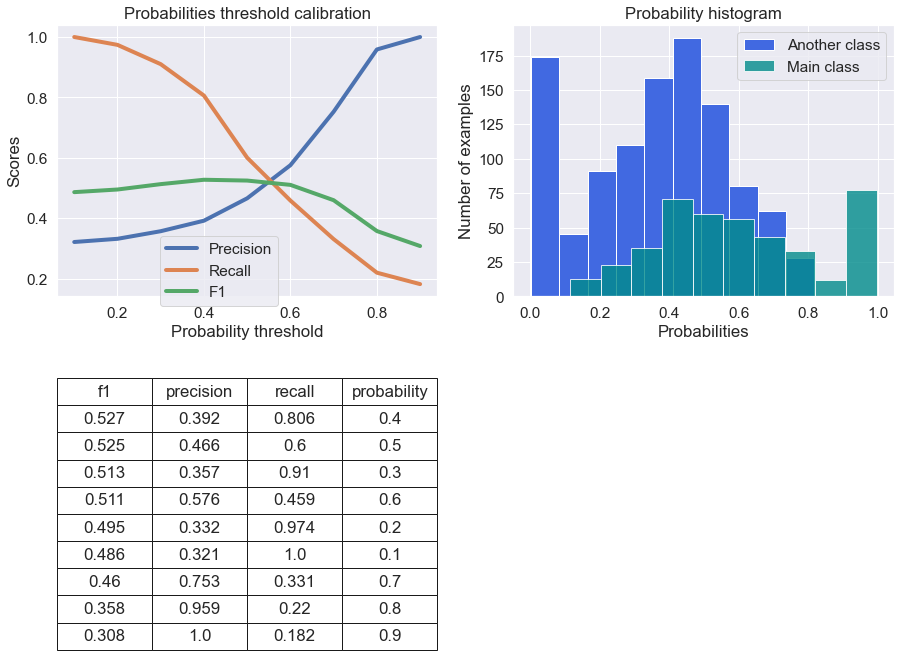

In [292]:
show_proba_calibration_plots(y_pred_proba[:, 1], y_test)

### Разберусь с дисбалансом классов, попробую tomek и smote

In [295]:
smote_train = balance_df_by_target(train, 'Credit Default', method='smote')
smote_train['Years in current job'] = smote_train['Years in current job'].astype('int')
X_smote = smote_train.drop(columns='Credit Default')
y_smote = smote_train['Credit Default']
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, random_state=42, test_size=0.2)


In [296]:
smote_model_catb = CatBoostClassifier(random_state=42, 
                                silent=True, 
                                eval_metric='F1',
                                use_best_model=True,
                                cat_features=cat_features)
smote_model_catb.fit(X_train, y_train, eval_set=(X_test, y_test))
evaluate_preds(smote_model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      4306
           1       0.94      0.85      0.89      4313

    accuracy                           0.90      8619
   macro avg       0.90      0.90      0.90      8619
weighted avg       0.90      0.90      0.90      8619

TEST

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1081
           1       0.86      0.76      0.81      1074

    accuracy                           0.82      2155
   macro avg       0.83      0.82      0.82      2155
weighted avg       0.83      0.82      0.82      2155

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               953  128
1               257  817


#### Тут Smote показывает отличные результаты, но при загрузке предсказаний этой модели на каггл, качество низкое, примерно 0.4

In [144]:
# test['Years in current job'] = test['Years in current job'].astype('int')
prediction = smote_model_catb.predict(test)

In [145]:
# submission = pd.read_csv('sample_submission.csv')
# submission['Credit Default'] = prediction
# submission.to_csv('final_smote_catb_submission', index=False)

In [305]:
tomek_train = balance_df_by_target(train, 'Credit Default', method='tomek')
tomek_train['Years in current job'] = tomek_train['Years in current job'].astype('int')
X_tomek = tomek_train.drop(columns='Credit Default')
y_tomek = tomek_train['Credit Default']
X_train, X_test, y_train, y_test = train_test_split(X_tomek, y_tomek, random_state=42, test_size=0.2)

In [299]:
tomek_model_catb2 = CatBoostClassifier(random_state=42)
grid_search = tomek_model_catb2.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.5060560823
bestIteration = 49

0:	loss: 0.5060561	best: 0.5060561 (0)	total: 155ms	remaining: 2.32s

bestTest = 0.4860323293
bestIteration = 189

1:	loss: 0.4860323	best: 0.4860323 (1)	total: 684ms	remaining: 4.79s

bestTest = 0.4813543999
bestIteration = 299

2:	loss: 0.4813544	best: 0.4813544 (2)	total: 1.47s	remaining: 6.37s

bestTest = 0.4790686709
bestIteration = 494

3:	loss: 0.4790687	best: 0.4790687 (3)	total: 2.72s	remaining: 8.15s

bestTest = 0.5029573971
bestIteration = 49

4:	loss: 0.5029574	best: 0.4790687 (3)	total: 2.86s	remaining: 6.28s

bestTest = 0.4815317747
bestIteration = 195

5:	loss: 0.4815318	best: 0.4790687 (3)	total: 3.47s	remaining: 5.79s

bestTest = 0.4785007436
bestIteration = 299

6:	loss: 0.4785007	best: 0.4785007 (6)	total: 4.36s	remaining: 5.6s

bestTest = 0.4777320941
bestIteration = 364

7:	loss: 0.4777321	best: 0.4777321 (7)	total: 5.89s	remaining: 5.89s

bestTest = 0.5008266604
bestIteration = 49

8:	loss: 0.5008267	best: 0.4777321 (7)

In [300]:
grid_search

{'params': {'depth': 5, 'iterations': 500},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
       

#### При глубине 3, а не 5, f1 на тесте все же получается лучше, получаем небольшое переобучение и хороший результат, на каггле он составляет 0.6 на паблике

In [303]:
tomek_model_catb2 = CatBoostClassifier(**init_params, depth=3, iterations=500)
tomek_model_catb2.fit(X_train, y_train)
evaluate_preds(tomek_model_catb2, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.72      0.79      3896
           1       0.55      0.78      0.64      1687

    accuracy                           0.74      5583
   macro avg       0.71      0.75      0.72      5583
weighted avg       0.78      0.74      0.75      5583

TEST

              precision    recall  f1-score   support

           0       0.85      0.69      0.76       970
           1       0.50      0.71      0.59       426

    accuracy                           0.70      1396
   macro avg       0.67      0.70      0.67      1396
weighted avg       0.74      0.70      0.71      1396

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               667  303
1               122  304


In [138]:
prediction = tomek_model_catb2.predict(test)

In [139]:
# submission = pd.read_csv('sample_submission.csv')
# submission['Credit Default'] = prediction
# submission.to_csv('tomek_catb_submission', index=False)